In [2]:
import pandas as pd
import numpy as np
import ast
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, balanced_accuracy_score

In [3]:
X_train = pd.read_csv("x_train.csv")
y_train = pd.read_csv("y_train.csv")
X_test  = pd.read_csv("x_test.csv")

In [4]:
print(X_train.shape, y_train.shape, X_test.shape)
print(X_train.describe())
print(X_train.head())
print(y_train.head())

(15882, 3) (15882, 3) (1819, 3)
         session_id
count  15882.000000
mean    7940.500000
std     4584.882823
min        0.000000
25%     3970.250000
50%     7940.500000
75%    11910.750000
max    15881.000000
   session_id                                   job_ids  \
0           0  [305, 299, 300, 290, 282, 274, 264, 261]   
1           1                       [84, 257, 252, 250]   
2           2       [241, 237, 221, 309, 310, 306, 301]   
3           3  [303, 297, 296, 298, 294, 295, 292, 293]   
4           4            [171, 291, 289, 166, 288, 155]   

                                             actions  
0  ['view', 'view', 'view', 'view', 'view', 'view...  
1                   ['view', 'view', 'view', 'view']  
2  ['view', 'view', 'apply', 'apply', 'apply', 'a...  
3  ['apply', 'apply', 'apply', 'apply', 'apply', ...  
4  ['apply', 'apply', 'apply', 'apply', 'apply', ...  
   session_id  job_id action
0           0      84   view
1           1     241   view
2           2   

## Job-to-job transition matrix

In [10]:
def to_list(x):
    return ast.literal_eval(x) if isinstance(x, str) else x

X_train["job_ids_list"] = X_train["job_ids"].apply(to_list)

df = X_train.merge(y_train[["session_id", "job_id"]], on="session_id")

df["full_sequence"] = df.apply(
    lambda row: row["job_ids_list"] + [row["job_id"]],
    axis=1
)

df = df[["session_id", "full_sequence"]]
df


,session_id,full_sequence
0,0,"[305, 299, 300, 290, 282, 274, 264, 261, 84]"
1,1,"[84, 257, 252, 250, 241]"
2,2,"[241, 237, 221, 309, 310, 306, 301, 303]"
3,3,"[303, 297, 296, 298, 294, 295, 292, 293, 171]"
4,4,"[171, 291, 289, 166, 288, 155, 286]"
...,...,...
15877,15877,"[26581, 27314, 27305, 27327, 27138, 27153, 27055]"
15878,15878,"[27220, 27219, 27194, 16013]"
15879,15879,"[27211, 27210, 27209, 27208]"
15880,15880,"[27233, 27220, 27219, 27232, 27231, 27230]"


In [11]:
from collections import defaultdict

transitions = defaultdict(int)

for seq in df["full_sequence"]:
    for i in range(len(seq) - 1):
        transitions[(seq[i], seq[i+1])] += 1

In [13]:
trans_df = (
    pd.DataFrame(
        [(k[0], k[1], v) for k, v in transitions.items()],
        columns=["from_job", "to_job", "count"]
    )
)

trans_df.describe()


,from_job,to_job,count
count,104932.000000,104932.000000,104932.000000
mean,6376.882972,6293.317730,1.141187
std,7807.671217,7748.776376,0.582889
min,0.000000,0.000000,1.000000
25%,1005.000000,977.000000,1.000000
50%,2680.000000,2619.000000,1.000000
75%,8501.250000,8424.250000,1.000000
max,27368.000000,27367.000000,20.000000


In [14]:
trans_df["prob"] = (
    trans_df["count"] /
    trans_df.groupby("from_job")["count"].transform("sum")
)

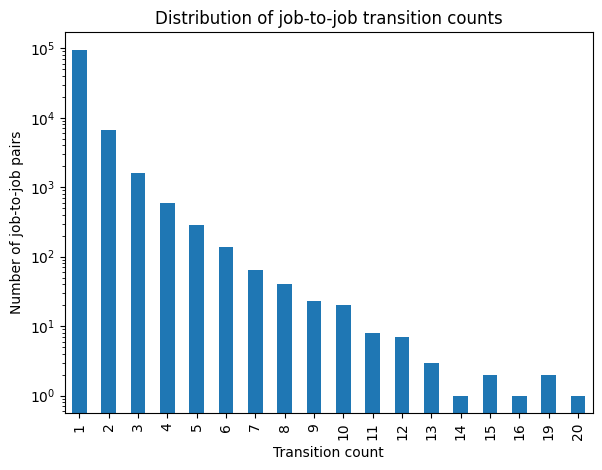

In [19]:
trans_df.describe()
trans_df['count'].value_counts

trans_df["count"].value_counts().sort_index().plot(kind="bar")
plt.xlabel("Transition count")
plt.ylabel("Number of job-to-job pairs")
plt.title("Distribution of job-to-job transition counts")
plt.tight_layout()
plt.yscale("log")
plt.show()


In [20]:
def recommend_next_jobs(last_job, trans_df, k=10):
    recs = (
        trans_df[trans_df["from_job"] == last_job]
        .sort_values("prob", ascending=False)
        .head(k)
    )
    return recs["to_job"].tolist()


In [ ]:
all_jobs = set()

for seq in df["full_sequence"]:
    all_jobs.update(seq)
    
from_jobs = set(trans_df["from_job"].unique())

never_seen_jobs = all_jobs - from_jobs

len(never_seen_jobs)

list(never_seen_jobs)

[22531,
 4,
 14347,
 12301,
 18445,
 26640,
 17,
 22548,
 22,
 12310,
 12312,
 16410,
 20515,
 10279,
 16426,
 14381,
 26669,
 24634,
 16443,
 22588,
 16445,
 16446,
 24638,
 12358,
 16462,
 18510,
 14420,
 4191,
 10337,
 14434,
 16493,
 14446,
 18542,
 20590,
 22644,
 10358,
 12406,
 6269,
 24702,
 8321,
 14468,
 14474,
 14478,
 12434,
 20633,
 18587,
 14492,
 16552,
 2219,
 12492,
 16610,
 18662,
 16630,
 14586,
 26885,
 24845,
 18717,
 2348,
 22841,
 14650,
 8507,
 317,
 8509,
 26945,
 14666,
 14680,
 16731,
 4448,
 22880,
 20836,
 22885,
 24953,
 16762,
 2428,
 16772,
 18827,
 399,
 6548,
 14759,
 18858,
 12716,
 12729,
 22973,
 16833,
 12739,
 20932,
 10696,
 14795,
 6604,
 16850,
 16858,
 10721,
 14824,
 12780,
 4611,
 14852,
 18947,
 25098,
 14869,
 16917,
 18967,
 21017,
 14876,
 8734,
 12831,
 10784,
 23079,
 18993,
 23093,
 23094,
 27190,
 23111,
 27208,
 19017,
 8787,
 14932,
 21078,
 20472,
 23128,
 16987,
 14940,
 27230,
 10855,
 10857,
 25197,
 8824,
 4728,
 21114,
 21132